## Classifier

In [1]:
import torch
import torchvision
from torchvision import transforms 
from torch.utils.data import Dataset, DataLoader
import os
import glob
import io


In [2]:
device = torch.device('cpu')  if torch.backends.mps.is_available() else torch.device('cpu')

torch.manual_seed(787)
if device == 'cpu':
    torch.manual_seed(787)
    
print(torch.__version__, torch.backends.mps.is_available())

1.12.1 True


In [3]:
# 경로 지정
import pandas as pd

train_path = '/Users/krc/Documents/breast_dacon/open/train_small'
test_path = '/Users/krc/Documents/breast_dacon/open/test_imgs'
%cd /Users/krc/Documents/breast_dacon/open
# Dataset_path = '/content/drive/MyDrive/파이토치/solo_project'

# based on table - 
train_df = pd.read_csv('./train.csv')



/Users/krc/Documents/breast_dacon/open


In [4]:
from sklearn.model_selection import train_test_split
train_df, test_df, train_labels, test_labels = train_test_split(
                                                    train_df.drop(columns=['N_category']),
                                                    train_df['N_category'], 
                                                    test_size=0.1,  # 0.2 
                                                    random_state=787
                                                )

In [5]:
os.getcwd()

'/Users/krc/Documents/breast_dacon/open'

In [6]:
from PIL import Image
import cv2
# import tensorflow as tf # 얜 왜.. ? 

class inhovation_Dataset(Dataset):
    
    def __init__(self, df, labels, transform=None):
        self.df = df
        self.labels = labels.tolist()
        self.transform = transform
        
    def __getitem__(self, index):
        
        if torch.is_tensor(index):
            index = index.tolist() # 이거 왜 list .. ?
            print( index, type(index))
        data_path = f"./train_small/{self.df['img_path'].iloc[index][13:]}"
        image = cv2.imread(data_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #transform 
        if self.transform is not None:
            augmented = self.transform(image = image)
            image = augmented['image']
            
        # label
        if self.labels is not None:
            label = self.labels[index]
            return image, label
        else:
            return image # for test dataset
    def __len__(self):
        length = len(self.df)
        return length

In [7]:
import albumentations
# !pip install Pillow==8.2.0
import albumentations.pytorch

albumentations_train = albumentations.Compose([

    albumentations.Resize(512, 512),
    albumentations.OneOf([
                            albumentations.HorizontalFlip(p=0.5),
                            # albumentations.RandomRotate90(p=0.8),
                            albumentations.VerticalFlip(p=0.5)
        
    ], p=1),
    albumentations.OneOf([
                            albumentations.MotionBlur(p=0.5),
                            albumentations.OpticalDistortion(p=0.5),
                            albumentations.GaussNoise(p=0.5)
        
        
    ], p=1),
    albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    albumentations.pytorch.transforms.ToTensorV2()
    ])

albumentations_test = albumentations.Compose([
    
    albumentations.Resize(512, 512),
    albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    albumentations.pytorch.transforms.ToTensorV2()
    
])

trainset = inhovation_Dataset(train_df, labels=train_labels, transform = albumentations_train)
testset = inhovation_Dataset(test_df, labels=test_labels,transform = albumentations_train)

albumentations_train_loader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                                         shuffle = True, num_workers=0)
albumentations_test_loader = torch.utils.data.DataLoader(testset, batch_size=16,
                                                        shuffle = False, num_workers=0)

In [8]:
# fine tuning

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [9]:
#import resnet

from torchvision import models
import torch.nn as nn
import torch.optim as optim

resnet50 = models.resnet50(weights=True).to(device)

resnet50.fc
#resnet50.fc = nn.Linear(resnet50.fc.in_fearues, 3).to(device)

/Users/krc/miniforge3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=2048, out_features=1000, bias=True)

In [10]:
resnet50.fc = nn.Sequential(
            nn.Linear(in_features=2048, out_features=256),
            nn.LeakyReLU(),

            nn.Linear(in_features=256, out_features=128),
            nn.LeakyReLU(),

            nn.Linear(in_features=128, out_features=1),
            nn.Sigmoid(),
        ) # this part can be finetuned
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
#!pip install torchsummary
from torchsummary import summary

summary(resnet50, input_size = (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
           Conv2d-13        [-1, 256, 128, 128]          16,384
      BatchNorm2d-14        [-1, 256, 1

torch.Size([64, 3, 7, 7])


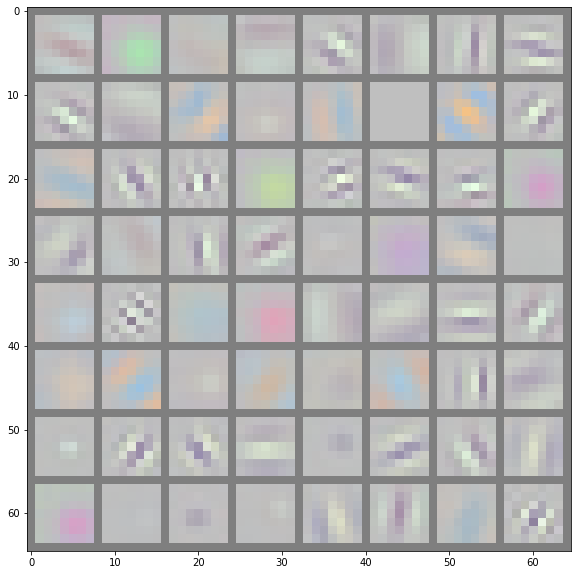

In [12]:
# check the first layer

for w in resnet50.parameters():
    w = w.data.cpu()
    print(w.shape)
    break
    
#weight renormalization
min_w = torch.min(w)
w1 = (-1 / (2*min_w)) *w + 0.5

# make grid
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = torchvision.utils.make_grid(x_grid, nrow = 8, padding=1)

plt.figure(figsize = (10,10))
imshow(x_grid)

In [13]:
#모델 저장 함수

def save_model(model, save_dir):
    os.makedirs(save_dir, exist_ok = True)
    check_point = {
        'net': model.state_dict(),
    }
    output_path = os.path.join(save_dir)
    torch.save(check_point, save_dir+'/best_model_weight.pth')


In [14]:
#model train
class Config:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)


In [15]:
from sklearn import metrics

class train_test():
    def __init__(self, config):
        self.trainloader = config.trainloader
        self.testloader = config.testloader
        self.model = config.model
        self.device = config.device
        self.optimizer = config.optimizer
        self.criterion = config.criterion
        self.globaliter = config.globaliter
        print('trainloader:', len(self.trainloader))
        
    def train(self, epochs):
        self.model.train()
        best_score =0
        best_model = None
        for epoch in range(1, epochs+1):
            running_loss = 0.0
            for i, data in enumerate(self.trainloader):
                self.globaliter +=1
                threshold = 0.5
                inputs, labels = data
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                self.optimizer.zero_grad()
                
                outputs = self.model(inputs)
                outputs = outputs.squeeze(1).to(device)

                loss = self.criterion(outputs, labels.float())
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
            print(f'train epoch {epoch} is done')
                     
            with torch.no_grad(): #validation
                self.model.eval()
                test_loss =[]
                f1_score =[]
                threshold = 0.
                for k, data in enumerate(self.testloader, 0):
                    images, label = data
                    images = images.to(self.device)
                    labels = label.to(self.device)
                    print( 'target:', label, type(label), labels)
                    test_outputs = self.model(images)
                    test_outputs = test_outputs.squeeze(1).to(device)
                    
                    #_, predicted = torch.max(outputs.data, 1)
                    # total += labels.size(0)
                    # correct += (predicted == labels).sum().item()
                    print('pred_labels',test_outputs, type(test_outputs))
                    test_loss.append(self.criterion(test_outputs, labels.float()))
                    pred_labels = np.where(np.array(test_outputs) > threshold, 1, 0)
                    score = metrics.f1_score(y_true=labels, y_pred=pred_labels, average='macro')
                    f1_score.append(score)
                print(f'Epoch [{epoch}], Train Loss : [{loss:.5f}] Val Loss : [{np.mean(test_loss):.5f}] f1 Score : [{np.mean(f1_score):.5f}]')
            if best_score < score:
                best_score = score
                best_model = self.model
                save_model(best_model, './models')
            print(f'epoch {epoch} is saved')
        return best_model
                    
        print('train finished')
            

In [16]:
lr = 0.005

config = Config(
    trainloader = albumentations_train_loader,
    testloader = albumentations_test_loader,
    model = resnet50, 
    device = device, 
    
    optimizer = torch.optim.Adam(resnet50.parameters(), lr = lr),
    criterion = nn.BCEWithLogitsLoss().to(device), #CrossEntropyLoss().to(device),
    globaliter=0

        )

In [17]:
ready_to_train=train_test(config)

trainloader: 57


In [20]:
lr_sche = optim.lr_scheduler.CosineAnnealingLR(config.optimizer, T_max =20) 
epochs = 20


model_done= ready_to_train.train(epochs)

train epoch 1 is done
target: tensor([0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1]) <class 'torch.Tensor'> tensor([0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1])
pred_labels tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) <class 'torch.Tensor'>
target: tensor([1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1]) <class 'torch.Tensor'> tensor([1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1])
pred_labels tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) <class 'torch.Tensor'>
target: tensor([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1]) <class 'torch.Tensor'> tensor([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1])
pred_labels tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) <class 'torch.Tensor'>
target: tensor([0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0]) <class 'torch.Tensor'> tensor([0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0])
pred_labels tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

KeyboardInterrupt: 

model based on https://github.com/inhovation97/Image_classification_pipeline_Project/blob/main/pytorch/pytorch_project_fine_tuning.ipynb

In [ ]:
## submission
test_csv = pd.read_csv('./test.csv')
test_dataset = inhovation_Dataset(test_csv, None, transform = albumentations_test)
test_data = torch.utils.data.DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    preds = []
    threshold = 0.5
    
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.float().to(device)
            
            model_pred = model(im)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            
            preds += model_pred.tolist()
    
    preds = np.where(np.array(preds) > threshold, 1, 0)
    
    return preds

In [ ]:
preds = inference(infer_model, test_data, device)

In [ ]:
preds = inference(infer_model, test_data, device)

In [ ]:
submit['N_category'] = preds
submit.to_csv('./submit.csv', index=False)